<a href="https://colab.research.google.com/github/Sirabhop/Preclinical-AD-EEG-classification/blob/master/Machine_Learning_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Set working directory and import cookbook
os.chdir("/content/drive/My Drive/Colab Notebooks/")

#Download eeg feature extraction function
%run EEG_Feature_Extraction.ipynb

# **Import Data**

In [0]:
#Compute EEG feature
os.chdir("/content/drive/My Drive/EEG Data")
subjectID = ['SS2', 'SS4', 'SS5', 'SS6', 'SS7', 'SS8']
#EEG_feature = extract_feature(subjectID)

In [0]:
#Import FCSRT
FCSRT = pd.read_csv("FCSRT.csv")
FCSRT_o = FCSRT.iloc[[2, 3,4,5,6,7], 1:]
FCSRT_o.reset_index(drop = True, inplace = True)

#Import MoCA
MoCA = pd.read_csv("MoCA.csv", usecols = ['SUM'])
MoCA.rename({'SUM':'MoCA'}, inplace = True, axis = 1)
MoCA_o = MoCA.iloc[[1,3,4,5,6,7]]
MoCA_o.reset_index(drop = True, inplace = True)

#Import EEG
EEG = pd.read_csv("/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA/EEG_features.csv")

#Create group
Group = pd.DataFrame(data = {'group':(1,0,1,1,0,0)})

#Combined data
df_original = pd.concat([Group, EEG, FCSRT_o , MoCA_o] , axis = 1)
df_original['group'] = df_original['group'].astype('category')

In [7]:
df_original.head()

,group,id,IR-PSD_Delta,IR-PSD_Theta,IR-PSD_Alpha,IR-PSD_Beta,IR-PSD_Gamma,IR-MSF,IR-SE,IR-AC,IR-wSMI_Alpha,IR-wSMI_Theta,DL-PSD_Delta,DL-PSD_Theta,DL-PSD_Alpha,DL-PSD_Beta,DL-PSD_Gamma,DL-MSF,DL-SE,DL-AC,DL-wSMI_Alpha,DL-wSMI_Theta,WCST-PSD_Delta,WCST-PSD_Theta,WCST-PSD_Alpha,WCST-PSD_Beta,WCST-PSD_Gamma,WCST-MSF,IR-FreeR,IR-CuedR,DL-FreeR,DL-CuedR,MoCA
0,1,SS2,2.054468e-13,1.524963e-12,1.524963e-12,7.768703e-13,3.475635e-13,2.666441e-13,5.133521,0.050399,0.027892,0.015981,1.961788e-13,1.525327e-12,1.525327e-12,6.838229e-13,3.152028e-13,2.811118e-13,5.089704,0.055408,0.032695,0.014258,1.826757e-13,1.120930e-12,1.120930e-12,1.002163e-12,1.432772e-13,2.409787e-13,11,4,11,4,7
1,0,SS4,5.475750e-13,7.600708e-12,7.600708e-12,1.002692e-12,8.041770e-13,3.324048e-13,5.085171,0.044436,0.025159,0.013004,5.962930e-10,4.424420e-09,4.424420e-09,2.878444e-10,4.177453e-11,4.212708e-13,5.313078,0.056617,0.021383,0.009044,1.915302e-13,2.267646e-12,2.267646e-12,7.699860e-13,8.153512e-13,4.067032e-13,11,4,11,5,22
2,1,SS5,1.956504e-13,1.580025e-12,1.580025e-12,9.415630e-13,4.302233e-13,2.967245e-13,5.102375,0.059466,0.038813,0.018355,1.824046e-13,1.715900e-12,1.715900e-12,9.682811e-13,4.674879e-13,2.634610e-13,5.111125,0.057658,0.036652,0.018399,8.227943e-14,5.882798e-13,5.882798e-13,6.867437e-13,1.772431e-13,1.899997e-13,10,4,7,7,12
3,1,SS6,9.339271e-14,6.523108e-13,6.523108e-13,2.567939e-13,1.605897e-13,1.187664e-13,5.167918,0.052925,0.032111,0.014805,1.008870e-13,8.745897e-13,8.745897e-13,5.370193e-13,6.309129e-13,1.637344e-13,5.194672,0.057270,0.034637,0.012544,1.289384e-13,1.777061e-12,1.777061e-12,5.819538e-13,3.057082e-13,2.090825e-13,6,4,6,4,15
4,0,SS7,2.956208e-13,3.084754e-12,3.084754e-12,1.834515e-12,2.278971e-12,6.441187e-13,5.096824,0.054849,0.043572,0.012939,2.746076e-13,2.125060e-12,2.125060e-12,1.727646e-12,2.031999e-12,4.718942e-13,5.131756,0.061386,0.036631,0.014230,5.067762e-13,2.833341e-12,2.833341e-12,1.944532e-12,1.860888e-12,6.026784e-13,8,7,9,6,20


Get data summary

In [0]:
def mean_confidence_interval(data, confidence=0.95):
  import numpy as np
  import scipy.stats  


  a = 1.0 * np.array(data)
  n = len(a)
  m, se = np.mean(a), scipy.stats.sem(a)
  h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
  return m-h, m+h

In [0]:
df = df_original.drop(['id','group'], axis = 1)
ci = pd.DataFrame(columns=['lower', 'upper'])
for x in range(len(df.columns)):
  ci.loc[x] = mean_confidence_interval(df.iloc[:,x])
describe = df.describe.transpose()

In [0]:
describe['lower'] = ci['lower'].values
describe['upper'] = ci['upper'].values

#Export
describe.to_csv('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA/descriptive.csv')

# **Data Preprocessing**

#### **1) Scaling**

In [0]:
from sklearn import preprocessing

In [0]:
#Min-Max Scaling
df_original.drop('id', axis = 1, inplace = True)

scaler = preprocessing.MinMaxScaler()
df_original[df_original.columns] = scaler.fit_transform(df_original[df_original.columns])

df = df_original

#### **2) Feature Selection**
using filter method

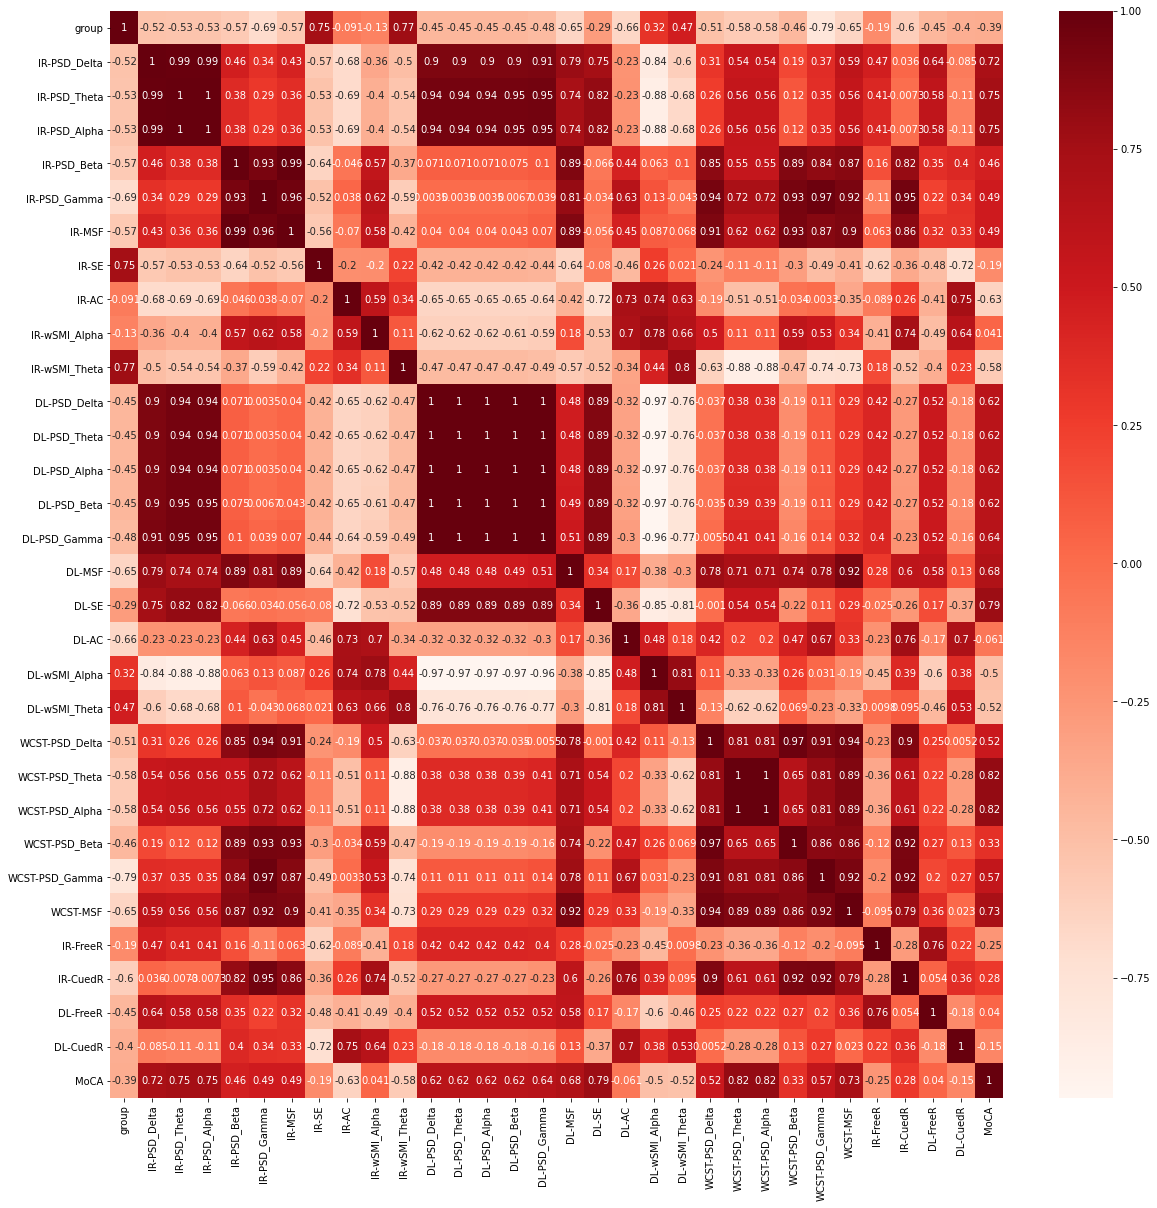

<Figure size 432x288 with 0 Axes>

In [88]:
plt.figure(figsize=(20,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/heatmap.png')

In [13]:
#Correlation with output variable
cor_target = abs(cor["group"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

group             1.000000
IR-PSD_Delta      0.521704
IR-PSD_Theta      0.534890
IR-PSD_Alpha      0.534890
IR-PSD_Beta       0.571819
IR-PSD_Gamma      0.694848
IR-MSF            0.566841
IR-SE             0.753698
IR-wSMI_Theta     0.772914
DL-MSF            0.648706
DL-AC             0.659458
WCST-PSD_Delta    0.512712
WCST-PSD_Theta    0.575492
WCST-PSD_Alpha    0.575492
WCST-PSD_Gamma    0.785494
WCST-MSF          0.648561
IR-CuedR          0.603023
Name: group, dtype: float64

In [0]:
selected_features = pd.DataFrame(relevant_features)
selected_features.reset_index(inplace = True)
selected_features.drop([0], inplace = True)

In [15]:
array_selected = selected_features['index'].to_numpy()
array_selected

array(['IR-PSD_Delta', 'IR-PSD_Theta', 'IR-PSD_Alpha', 'IR-PSD_Beta',
       'IR-PSD_Gamma', 'IR-MSF', 'IR-SE', 'IR-wSMI_Theta', 'DL-MSF',
       'DL-AC', 'WCST-PSD_Delta', 'WCST-PSD_Theta', 'WCST-PSD_Alpha',
       'WCST-PSD_Gamma', 'WCST-MSF', 'IR-CuedR'], dtype=object)

# **Model Experimentation**

####**1) Seperate dataframe**


1.   Only EEG & MoCA data
2.   FCSRT & MoCA data
3. All data


In [60]:
df.columns

Index(['group', 'IR-PSD_Delta', 'IR-PSD_Theta', 'IR-PSD_Alpha', 'IR-PSD_Beta',
       'IR-PSD_Gamma', 'IR-MSF', 'IR-SE', 'IR-AC', 'IR-wSMI_Alpha',
       'IR-wSMI_Theta', 'DL-PSD_Delta', 'DL-PSD_Theta', 'DL-PSD_Alpha',
       'DL-PSD_Beta', 'DL-PSD_Gamma', 'DL-MSF', 'DL-SE', 'DL-AC',
       'DL-wSMI_Alpha', 'DL-wSMI_Theta', 'WCST-PSD_Delta', 'WCST-PSD_Theta',
       'WCST-PSD_Alpha', 'WCST-PSD_Beta', 'WCST-PSD_Gamma', 'WCST-MSF',
       'IR-FreeR', 'IR-CuedR', 'DL-FreeR', 'DL-CuedR', 'MoCA'],
      dtype='object')

In [0]:
#1 Fitered Model
X_1 = df[array_selected]
#2 Hypothesis Model (1)
X_2 = df[['IR-FreeR', 'IR-CuedR','DL-FreeR', 'DL-CuedR']]
#3 Hypothesis Model (2)
X_3 = df[['IR-PSD_Delta', 'IR-PSD_Theta', 'IR-PSD_Alpha', 'IR-PSD_Beta',
          'IR-PSD_Gamma', 'IR-MSF', 'IR-SE', 'IR-AC', 'IR-wSMI_Alpha',
          'IR-wSMI_Theta', 'DL-PSD_Delta', 'DL-PSD_Theta', 'DL-PSD_Alpha',
          'DL-PSD_Beta', 'DL-PSD_Gamma', 'DL-MSF', 'DL-SE', 'DL-AC',
          'DL-wSMI_Alpha', 'DL-wSMI_Theta']]
#4 Hypothesis Model (3)
X_4 = df[['IR-PSD_Delta', 'IR-PSD_Theta', 'IR-PSD_Alpha', 'IR-PSD_Beta',
          'IR-PSD_Gamma', 'IR-MSF', 'IR-SE', 'IR-AC', 'IR-wSMI_Alpha',
          'IR-wSMI_Theta', 'DL-PSD_Delta', 'DL-PSD_Theta', 'DL-PSD_Alpha',
          'DL-PSD_Beta', 'DL-PSD_Gamma', 'DL-MSF', 'DL-SE', 'DL-AC',
          'DL-wSMI_Alpha', 'DL-wSMI_Theta',
          'IR-FreeR', 'IR-CuedR','DL-FreeR', 'DL-CuedR']]
y = df['group']

####**2) Seperate *Training Set* and *Test Set***

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
#X_1
X_1_train, X_1_test, Y_1_train,Y_1_test = train_test_split(X_1, y, test_size = 0.25, random_state = 0)

#X_2
X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, y, test_size = 0.25, random_state = 0)

#X_3
X_3_train, X_3_test, Y_3_train, Y_3_test = train_test_split(X_3, y, test_size = 0.25, random_state = 0)

#X_4
X_4_train, X_4_test, Y_4_train, Y_4_test = train_test_split(X_4, y, test_size = 0.25, random_state = 0)

####**3) Model Building**

In [0]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz

In [0]:
classifier_1 = SVC(kernel = 'rbf', random_state = 0)
classifier_1.fit(X_1_train, Y_1_train)
Y_1_pred = classifier_1.predict(X_1_test)

classifier_2 = SVC(kernel = 'rbf', random_state = 0)
classifier_2.fit(X_2_train, Y_2_train)
Y_2_pred = classifier_2.predict(X_2_test)

classifier_3 = SVC(kernel = 'rbf', random_state = 0)
classifier_3.fit(X_3_train, Y_3_train)
Y_3_pred = classifier_3.predict(X_3_test)

classifier_4 = SVC(kernel = 'rbf', random_state = 0)
classifier_4.fit(X_4_train, Y_3_train)
Y_4_pred = classifier_4.predict(X_4_test)

In [0]:
classifier_1 = DecisionTreeClassifier(min_samples_split = 5)
classifier_1.fit(X_1_train, Y_1_train)
Y_1_pred = classifier_1.predict(X_1_test)

classifier_2 = DecisionTreeClassifier()
classifier_2.fit(X_2_train, Y_2_train)
Y_2_pred = classifier_2.predict(X_2_test)

classifier_3 = DecisionTreeClassifier()
classifier_3.fit(X_3_train, Y_3_train)
Y_3_pred = classifier_3.predict(X_3_test)

classifier_4 = DecisionTreeClassifier()
classifier_4.fit(X_4_train, Y_4_train)
Y_4_pred = classifier_4.predict(X_4_test)

####**4) Model Evaluation**

In [0]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

In [0]:
def con_mat_picture(y_test, y_pred, title):
  title = title
  cm = confusion_matrix(y_test, y_pred)
  plt.imshow(cm, cmap=plt.cm.Greens)
  plt.xlabel("Predicted labels")
  plt.ylabel("True labels")

  plt.xticks([], []+ labels)
  plt.yticks([], []+ labels)
  plt.title(title)
  plt.colorbar()
  return plt.show()

In [0]:
def con_mat_picture(y_test, y_pred, title):
  cm = confusion_matrix(y_test, y_pred)
  title = title
  labels = ['Normal', 'Risk']

  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title(title)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  return plt.show()

####**SVM**

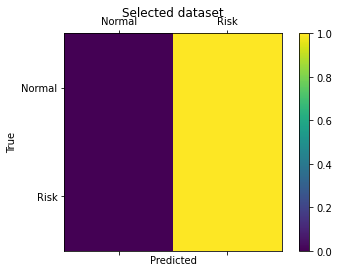

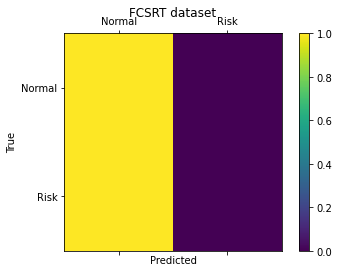

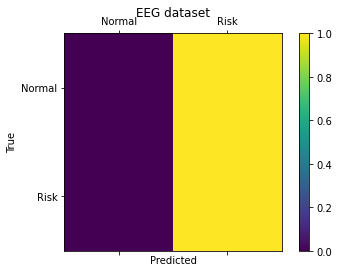

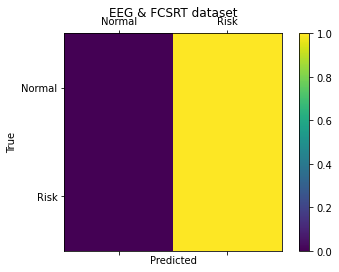

In [69]:
cm_1 = con_mat_picture(Y_1_test, Y_1_pred, 'Selected dataset')
cm_2 = con_mat_picture(Y_2_test, Y_2_pred, 'FCSRT dataset')
cm_3 = con_mat_picture(Y_3_test, Y_3_pred, 'EEG dataset')
cm_4 = con_mat_picture(Y_4_test, Y_4_pred, 'EEG & FCSRT dataset')

In [82]:
print(classification_report(Y_1_test, Y_1_pred))
print(classification_report(Y_2_test, Y_2_pred))
print(classification_report(Y_3_test, Y_3_pred))
print(classification_report(Y_4_test, Y_4_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              preci

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####**Decision Tree**

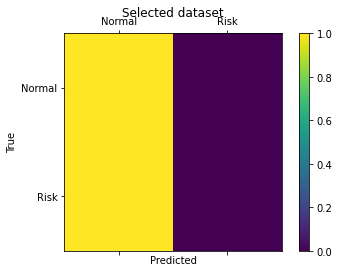

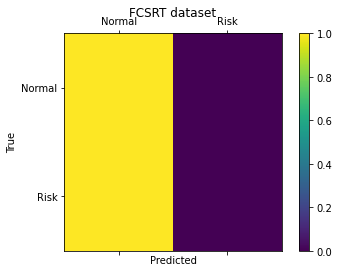

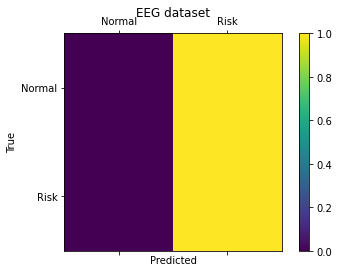

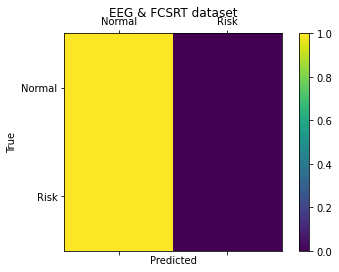

In [84]:
cm_1 = con_mat_picture(Y_1_test, Y_1_pred, 'Selected dataset')
cm_2 = con_mat_picture(Y_2_test, Y_2_pred, 'FCSRT dataset')
cm_3 = con_mat_picture(Y_3_test, Y_3_pred, 'EEG dataset')
cm_4 = con_mat_picture(Y_4_test, Y_4_pred, 'EEG & FCSRT dataset')

In [85]:
print(classification_report(Y_1_test, Y_1_pred))
print(classification_report(Y_2_test, Y_2_pred))
print(classification_report(Y_3_test, Y_3_pred))
print(classification_report(Y_4_test, Y_4_pred))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              preci

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
features = X_1.columns

[Text(167.4, 163.07999999999998, 'DL-CuedR <= 0.167\ngini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = Normal'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = Risk'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = Normal')]

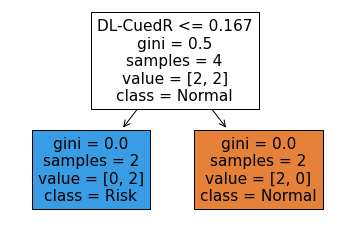

In [86]:
plot_tree(classifier_2, feature_names = ['IR-FreeR', 'IR-CuedR','DL-FreeR', 'DL-CuedR'], class_names = ['Normal', 'Risk'], filled = True)

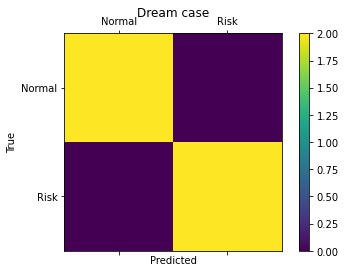

In [0]:
#Dream case
a = [0,0,1,1]
b = [0,0,1,1]

cm_3 = con_mat_picture(a, b, 'Dream case')